In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Uber-Jan-Feb-FOIL.csv")

# Display basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB
None
  dispatching_base_number      date  active_vehicles  trips
0                  B02512  1/1/2015              190   1132
1                  B02765  1/1/2015              225   1765
2                  B02764  1/1/2015             3427  29421
3                  B02682  1/1/2015              945   7679
4                  B02617  1/1/2015             1228   9537


In [3]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Optional: sort and set as index
df = df.sort_values(by='date')
df.set_index('date', inplace=True)


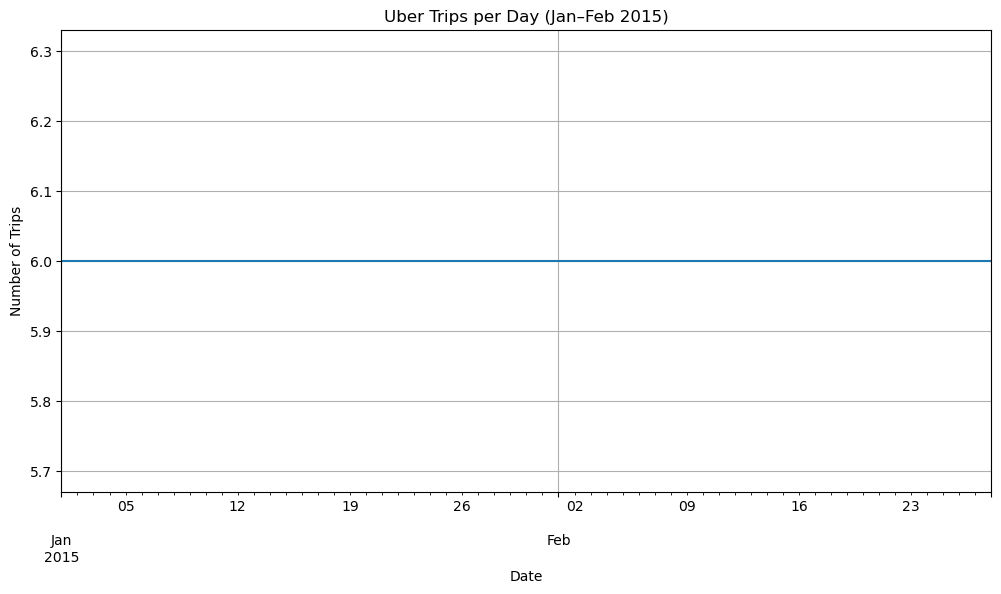

In [4]:
import matplotlib.pyplot as plt

# Count trips per day (if not already aggregated)
daily_trips = df.resample('D').size()

# Plot
plt.figure(figsize=(12,6))
daily_trips.plot()
plt.title('Uber Trips per Day (Jan–Feb 2015)')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()


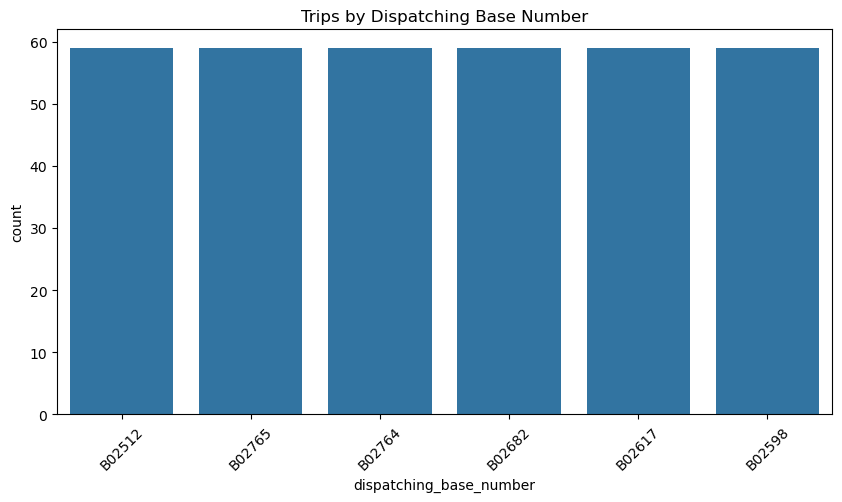

In [5]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(x='dispatching_base_number', data=df)
plt.title('Trips by Dispatching Base Number')
plt.xticks(rotation=45)
plt.show()


In [6]:
df['day'] = df.index.day
df['weekday'] = df.index.dayofweek
df['week'] = df.index.isocalendar().week
df['month'] = df.index.month


In [7]:
df = pd.get_dummies(df, columns=['dispatching_base_number'], drop_first=True)


In [8]:
# Aggregate trips by day for modeling
trip_series = df.resample('D').size().rename("trip_count")
trip_series = trip_series.to_frame()


In [9]:
def create_lagged_features(data, window=3):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return pd.DataFrame(X), pd.Series(y)

X, y = create_lagged_features(trip_series['trip_count'].values, window=3)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

R2 Score: 1.00
MAE: 0.00
MSE: 0.00


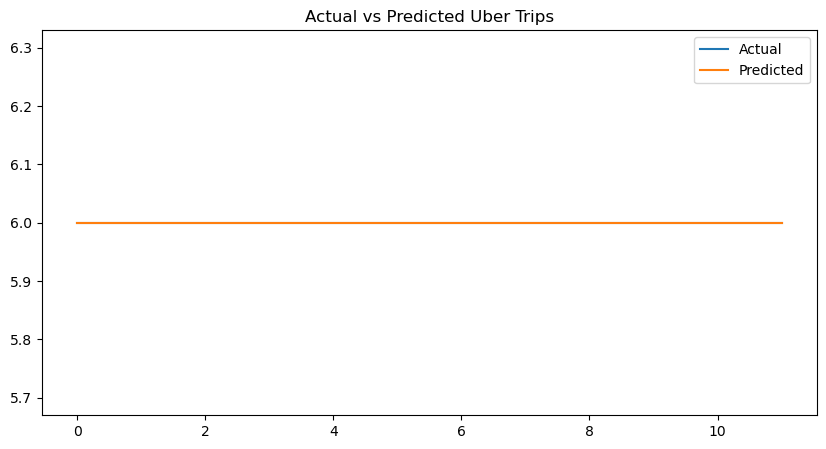

R2 Score: 1.00
MAE: 0.00
MSE: 0.00


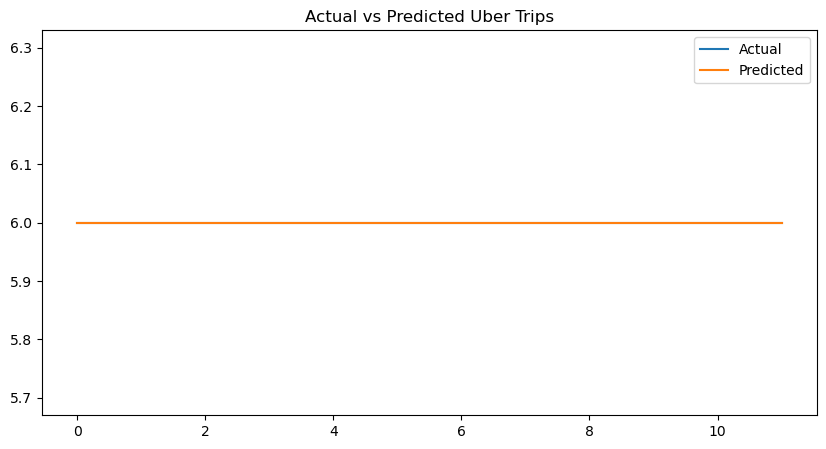

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    print(f"R2 Score: {r2_score(y_test, preds):.2f}")
    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"MSE: {mean_squared_error(y_test, preds):.2f}")
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.legend()
    plt.title("Actual vs Predicted Uber Trips")
    plt.show()

evaluate(rf, X_test, y_test)
evaluate(xgb, X_test, y_test)


In [15]:
ensemble_preds = (rf.predict(X_test) + xgb.predict(X_test)) / 2


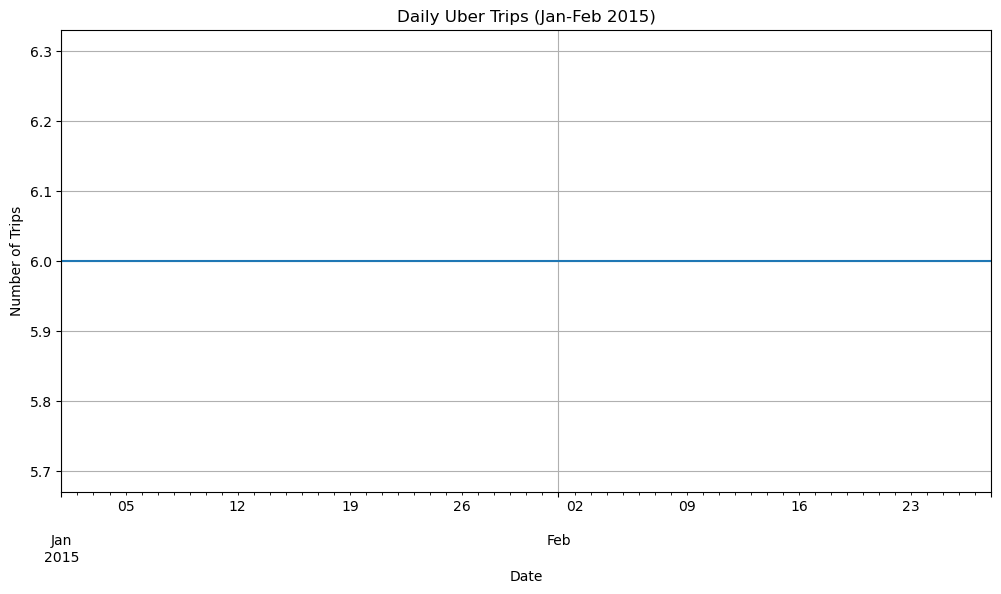

In [16]:
daily_trips = df.groupby('date').size()

plt.figure(figsize=(12,6))
daily_trips.plot()
plt.title('Daily Uber Trips (Jan-Feb 2015)')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()


In [19]:
print(df.columns)


Index(['active_vehicles', 'trips', 'day', 'weekday', 'week', 'month',
       'dispatching_base_number_B02598', 'dispatching_base_number_B02617',
       'dispatching_base_number_B02682', 'dispatching_base_number_B02764',
       'dispatching_base_number_B02765'],
      dtype='object')


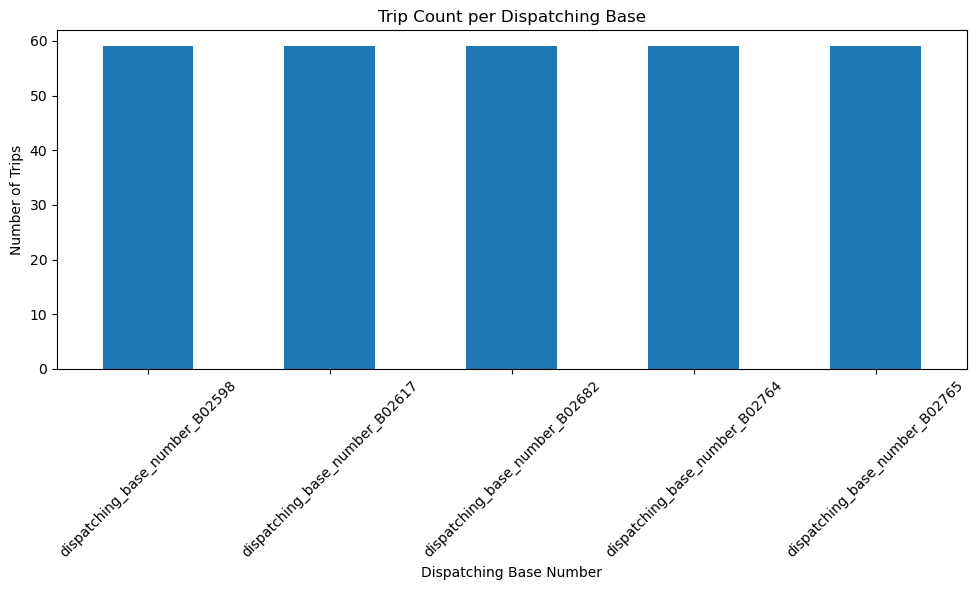

In [20]:
import matplotlib.pyplot as plt

# Extract only the one-hot base columns
base_columns = [col for col in df.columns if col.startswith('dispatching_base_number_')]

# Sum the trips per base
base_counts = df[base_columns].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
base_counts.plot(kind='bar')
plt.title('Trip Count per Dispatching Base')
plt.xlabel('Dispatching Base Number')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
